##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [8]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
# df.pop(...) remove the column
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [9]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

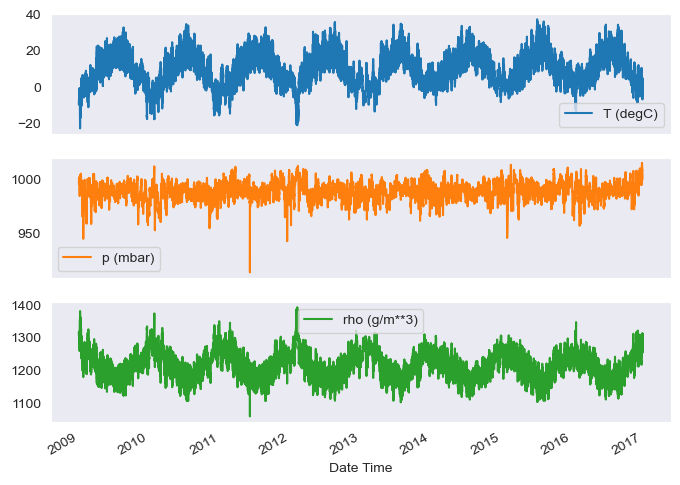

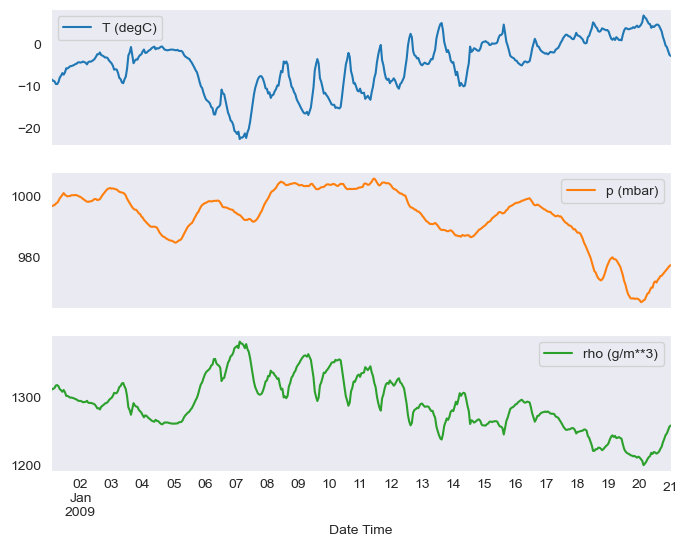

In [10]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# first 480 points
# plot_features = df[plot_cols][:480]
# plot_features.index = date_time[:480]
plot_features = plot_features[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [12]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

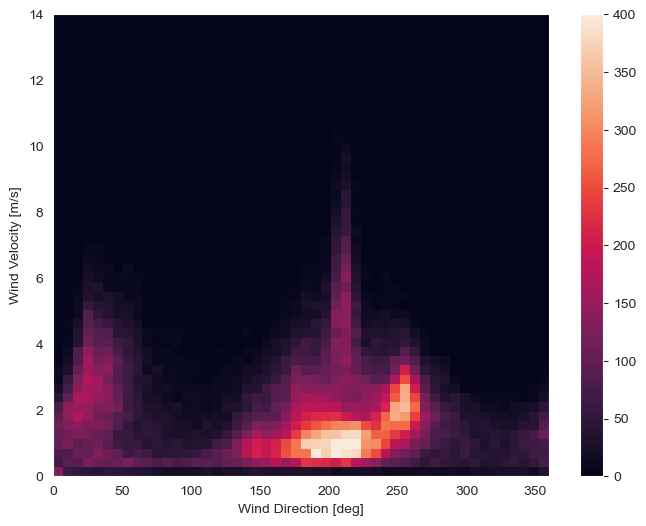

In [13]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [14]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

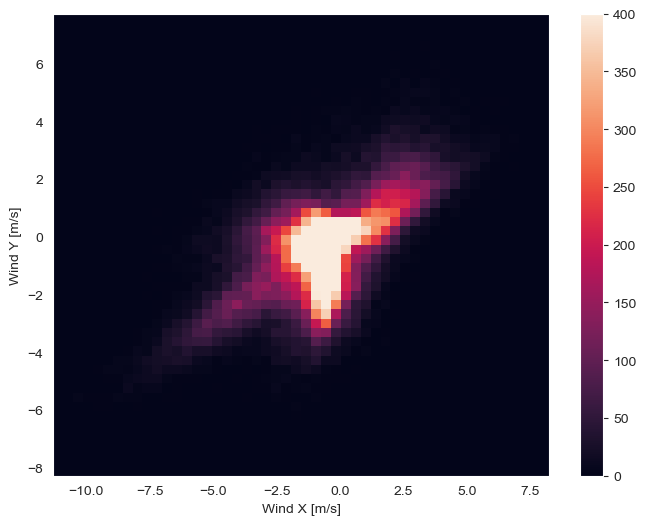

In [15]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [16]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [14]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

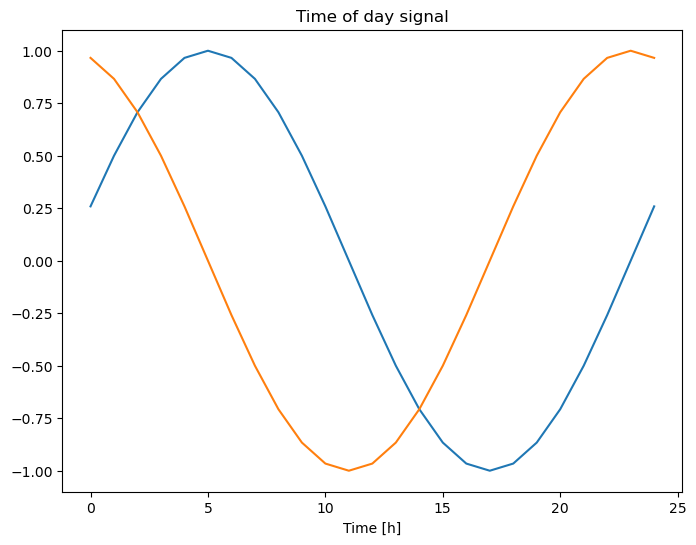

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


In [16]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

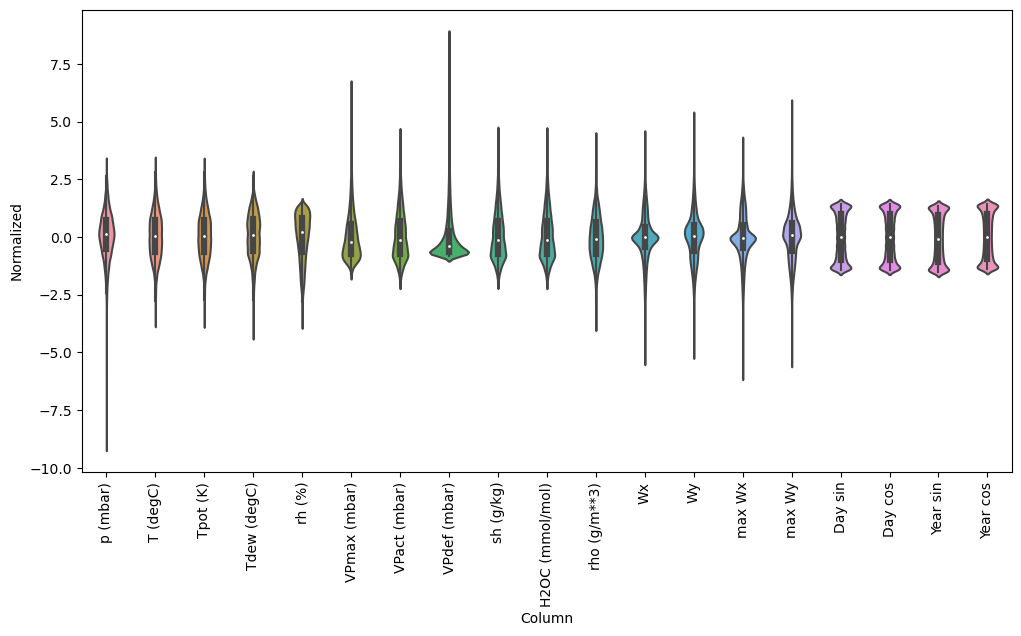

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [21]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [22]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

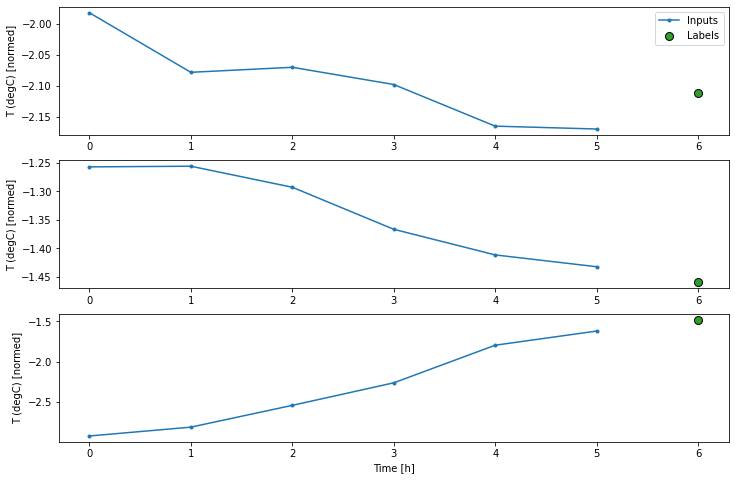

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

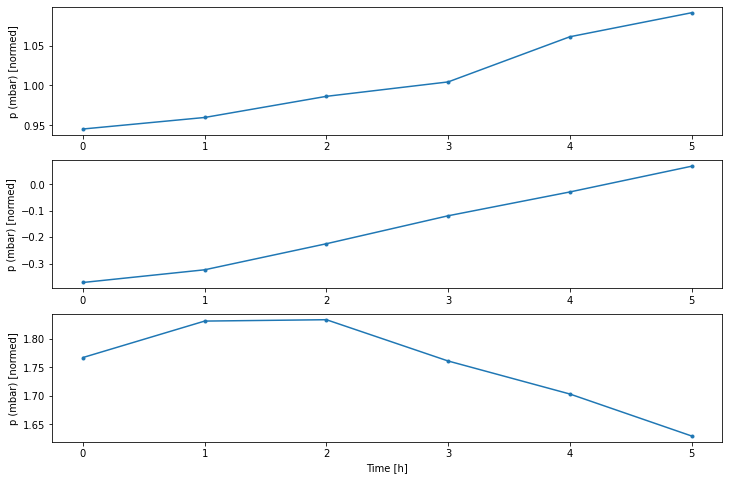

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:25 - loss: 0.0044 - mean_absolute_error: 0.0524

 28/439 [>.............................] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0747  

 55/439 [==>...........................] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0770

 81/439 [====>.........................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0789

108/439 [======>.......................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0792

136/439 [========>.....................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0789

163/439 [==========>...................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0783

190/439 [===========>..................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

217/439 [=============>................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0782

244/439 [===============>..............] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0781

272/439 [=================>............] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0781

300/439 [===================>..........] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0781

329/439 [=====================>........] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0779

357/439 [=======================>......] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

385/439 [=========================>....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

413/439 [===========================>..] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

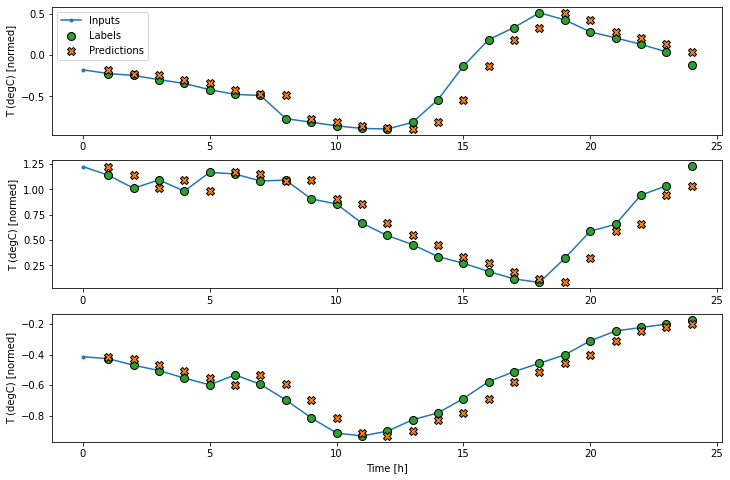

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 10:29 - loss: 3.2984 - mean_absolute_error: 1.5546

  20/1534 [..............................] - ETA: 4s - loss: 2.9098 - mean_absolute_error: 1.4522   

  40/1534 [..............................] - ETA: 3s - loss: 2.5141 - mean_absolute_error: 1.3239

  60/1534 [>.............................] - ETA: 3s - loss: 2.2665 - mean_absolute_error: 1.2574

  80/1534 [>.............................] - ETA: 3s - loss: 2.0463 - mean_absolute_error: 1.1849

 100/1534 [>.............................] - ETA: 3s - loss: 1.8462 - mean_absolute_error: 1.1158

 120/1534 [=>............................] - ETA: 3s - loss: 1.6723 - mean_absolute_error: 1.0530

 141/1534 [=>............................] - ETA: 3s - loss: 1.5159 - mean_absolute_error: 0.9929

 161/1534 [==>...........................] - ETA: 3s - loss: 1.3837 - mean_absolute_error: 0.9379

 181/1534 [==>...........................] - ETA: 3s - loss: 1.2733 - mean_absolute_error: 0.8897

 201/1534 [==>...........................] - ETA: 3s - loss: 1.1791 - mean_absolute_error: 0.8477

 221/1534 [===>..........................] - ETA: 3s - loss: 1.0949 - mean_absolute_error: 0.8077

 241/1534 [===>..........................] - ETA: 3s - loss: 1.0224 - mean_absolute_error: 0.7718

 261/1534 [====>.........................] - ETA: 3s - loss: 0.9586 - mean_absolute_error: 0.7404

 281/1534 [====>.........................] - ETA: 3s - loss: 0.9015 - mean_absolute_error: 0.7101

 301/1534 [====>.........................] - ETA: 3s - loss: 0.8512 - mean_absolute_error: 0.6830

 321/1534 [=====>........................] - ETA: 3s - loss: 0.8059 - mean_absolute_error: 0.6577

 341/1534 [=====>........................] - ETA: 3s - loss: 0.7654 - mean_absolute_error: 0.6351

 361/1534 [======>.......................] - ETA: 2s - loss: 0.7289 - mean_absolute_error: 0.6142

 381/1534 [======>.......................] - ETA: 2s - loss: 0.6954 - mean_absolute_error: 0.5945

 401/1534 [======>.......................] - ETA: 2s - loss: 0.6650 - mean_absolute_error: 0.5766

 421/1534 [=======>......................] - ETA: 2s - loss: 0.6371 - mean_absolute_error: 0.5596

 441/1534 [=======>......................] - ETA: 2s - loss: 0.6115 - mean_absolute_error: 0.5439

 461/1534 [========>.....................] - ETA: 2s - loss: 0.5882 - mean_absolute_error: 0.5293

 481/1534 [========>.....................] - ETA: 2s - loss: 0.5662 - mean_absolute_error: 0.5153

 502/1534 [========>.....................] - ETA: 2s - loss: 0.5449 - mean_absolute_error: 0.5014

 522/1534 [=========>....................] - ETA: 2s - loss: 0.5260 - mean_absolute_error: 0.4890

 542/1534 [=========>....................] - ETA: 2s - loss: 0.5085 - mean_absolute_error: 0.4775

 562/1534 [=========>....................] - ETA: 2s - loss: 0.4925 - mean_absolute_error: 0.4672

 582/1534 [==========>...................] - ETA: 2s - loss: 0.4772 - mean_absolute_error: 0.4570

 602/1534 [==========>...................] - ETA: 2s - loss: 0.4632 - mean_absolute_error: 0.4479

 622/1534 [===========>..................] - ETA: 2s - loss: 0.4497 - mean_absolute_error: 0.4386

 643/1534 [===========>..................] - ETA: 2s - loss: 0.4365 - mean_absolute_error: 0.4295

 664/1534 [===========>..................] - ETA: 2s - loss: 0.4239 - mean_absolute_error: 0.4208

 684/1534 [============>.................] - ETA: 2s - loss: 0.4128 - mean_absolute_error: 0.4131

 704/1534 [============>.................] - ETA: 2s - loss: 0.4023 - mean_absolute_error: 0.4059

 724/1534 [=============>................] - ETA: 2s - loss: 0.3923 - mean_absolute_error: 0.3989

 744/1534 [=============>................] - ETA: 2s - loss: 0.3828 - mean_absolute_error: 0.3921

 764/1534 [=============>................] - ETA: 1s - loss: 0.3737 - mean_absolute_error: 0.3857

 784/1534 [==============>...............] - ETA: 1s - loss: 0.3651 - mean_absolute_error: 0.3795

 804/1534 [==============>...............] - ETA: 1s - loss: 0.3569 - mean_absolute_error: 0.3737

 824/1534 [===============>..............] - ETA: 1s - loss: 0.3492 - mean_absolute_error: 0.3683

 844/1534 [===============>..............] - ETA: 1s - loss: 0.3417 - mean_absolute_error: 0.3628

 864/1534 [===============>..............] - ETA: 1s - loss: 0.3346 - mean_absolute_error: 0.3577

 884/1534 [================>.............] - ETA: 1s - loss: 0.3279 - mean_absolute_error: 0.3527

 905/1534 [================>.............] - ETA: 1s - loss: 0.3210 - mean_absolute_error: 0.3478

 925/1534 [=================>............] - ETA: 1s - loss: 0.3148 - mean_absolute_error: 0.3432

 945/1534 [=================>............] - ETA: 1s - loss: 0.3088 - mean_absolute_error: 0.3387

 965/1534 [=================>............] - ETA: 1s - loss: 0.3031 - mean_absolute_error: 0.3344

 985/1534 [==================>...........] - ETA: 1s - loss: 0.2975 - mean_absolute_error: 0.3302

1004/1534 [==================>...........] - ETA: 1s - loss: 0.2924 - mean_absolute_error: 0.3263

1024/1534 [===================>..........] - ETA: 1s - loss: 0.2873 - mean_absolute_error: 0.3225

1044/1534 [===================>..........] - ETA: 1s - loss: 0.2823 - mean_absolute_error: 0.3188

1063/1534 [===================>..........] - ETA: 1s - loss: 0.2777 - mean_absolute_error: 0.3153

1082/1534 [====================>.........] - ETA: 1s - loss: 0.2733 - mean_absolute_error: 0.3120

1102/1534 [====================>.........] - ETA: 1s - loss: 0.2688 - mean_absolute_error: 0.3085

1122/1534 [====================>.........] - ETA: 1s - loss: 0.2645 - mean_absolute_error: 0.3051

1142/1534 [=====================>........] - ETA: 1s - loss: 0.2603 - mean_absolute_error: 0.3020

1162/1534 [=====================>........] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.2989

1183/1534 [======================>.......] - ETA: 0s - loss: 0.2522 - mean_absolute_error: 0.2957

1203/1534 [======================>.......] - ETA: 0s - loss: 0.2485 - mean_absolute_error: 0.2928

1223/1534 [======================>.......] - ETA: 0s - loss: 0.2448 - mean_absolute_error: 0.2900

1243/1534 [=======================>......] - ETA: 0s - loss: 0.2412 - mean_absolute_error: 0.2871

1264/1534 [=======================>......] - ETA: 0s - loss: 0.2377 - mean_absolute_error: 0.2844

1284/1534 [========================>.....] - ETA: 0s - loss: 0.2344 - mean_absolute_error: 0.2818

1305/1534 [========================>.....] - ETA: 0s - loss: 0.2309 - mean_absolute_error: 0.2790

1325/1534 [========================>.....] - ETA: 0s - loss: 0.2278 - mean_absolute_error: 0.2765

1345/1534 [=========================>....] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.2740

1365/1534 [=========================>....] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2716

1386/1534 [==========================>...] - ETA: 0s - loss: 0.2187 - mean_absolute_error: 0.2691

1407/1534 [==========================>...] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2667

1428/1534 [==========================>...] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2644

1449/1534 [===========================>..] - ETA: 0s - loss: 0.2101 - mean_absolute_error: 0.2620

1469/1534 [===========================>..] - ETA: 0s - loss: 0.2075 - mean_absolute_error: 0.2598

1490/1534 [============================>.] - ETA: 0s - loss: 0.2048 - mean_absolute_error: 0.2577

1510/1534 [============================>.] - ETA: 0s - loss: 0.2024 - mean_absolute_error: 0.2557

1530/1534 [============================>.] - ETA: 0s - loss: 0.2000 - mean_absolute_error: 0.2538

1534/1534 [==============================] - 5s 3ms/step - loss: 0.1996 - mean_absolute_error: 0.2534 - val_loss: 0.0199 - val_mean_absolute_error: 0.1026


Epoch 2/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0232 - mean_absolute_error: 0.1033

  21/1534 [..............................] - ETA: 3s - loss: 0.0175 - mean_absolute_error: 0.1005 

  40/1534 [..............................] - ETA: 3s - loss: 0.0181 - mean_absolute_error: 0.0999

  59/1534 [>.............................] - ETA: 3s - loss: 0.0180 - mean_absolute_error: 0.0992

  79/1534 [>.............................] - ETA: 3s - loss: 0.0179 - mean_absolute_error: 0.0991

  99/1534 [>.............................] - ETA: 3s - loss: 0.0182 - mean_absolute_error: 0.1004

 119/1534 [=>............................] - ETA: 3s - loss: 0.0179 - mean_absolute_error: 0.0995

 139/1534 [=>............................] - ETA: 3s - loss: 0.0178 - mean_absolute_error: 0.0998

 158/1534 [==>...........................] - ETA: 3s - loss: 0.0180 - mean_absolute_error: 0.1005

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0180 - mean_absolute_error: 0.1004

 199/1534 [==>...........................] - ETA: 3s - loss: 0.0180 - mean_absolute_error: 0.1004

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0179 - mean_absolute_error: 0.1002

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0178 - mean_absolute_error: 0.1001

 258/1534 [====>.........................] - ETA: 3s - loss: 0.0177 - mean_absolute_error: 0.0997

 278/1534 [====>.........................] - ETA: 3s - loss: 0.0177 - mean_absolute_error: 0.0996

 298/1534 [====>.........................] - ETA: 3s - loss: 0.0177 - mean_absolute_error: 0.0996

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0176 - mean_absolute_error: 0.0996

 338/1534 [=====>........................] - ETA: 3s - loss: 0.0175 - mean_absolute_error: 0.0993

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0173 - mean_absolute_error: 0.0988

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0172 - mean_absolute_error: 0.0985

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0173 - mean_absolute_error: 0.0986

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0172 - mean_absolute_error: 0.0983

 438/1534 [=======>......................] - ETA: 2s - loss: 0.0171 - mean_absolute_error: 0.0980

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0170 - mean_absolute_error: 0.0977

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0169 - mean_absolute_error: 0.0973

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0169 - mean_absolute_error: 0.0972

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0168 - mean_absolute_error: 0.0970

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0167 - mean_absolute_error: 0.0968

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0167 - mean_absolute_error: 0.0967

 579/1534 [==========>...................] - ETA: 2s - loss: 0.0166 - mean_absolute_error: 0.0966

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0166 - mean_absolute_error: 0.0965

 619/1534 [===========>..................] - ETA: 2s - loss: 0.0165 - mean_absolute_error: 0.0962

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0164 - mean_absolute_error: 0.0959

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0163 - mean_absolute_error: 0.0956

 680/1534 [============>.................] - ETA: 2s - loss: 0.0162 - mean_absolute_error: 0.0953

 700/1534 [============>.................] - ETA: 2s - loss: 0.0161 - mean_absolute_error: 0.0951

 720/1534 [=============>................] - ETA: 2s - loss: 0.0161 - mean_absolute_error: 0.0949

 740/1534 [=============>................] - ETA: 2s - loss: 0.0160 - mean_absolute_error: 0.0946

 760/1534 [=============>................] - ETA: 1s - loss: 0.0159 - mean_absolute_error: 0.0943

 780/1534 [==============>...............] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0941

 800/1534 [==============>...............] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0939

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0937

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0935

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0933

 880/1534 [================>.............] - ETA: 1s - loss: 0.0155 - mean_absolute_error: 0.0931

 900/1534 [================>.............] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0929

 921/1534 [=================>............] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0927

 942/1534 [=================>............] - ETA: 1s - loss: 0.0153 - mean_absolute_error: 0.0925

 962/1534 [=================>............] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0923

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0921

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0150 - mean_absolute_error: 0.0917

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0150 - mean_absolute_error: 0.0915

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0149 - mean_absolute_error: 0.0913

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0148 - mean_absolute_error: 0.0911

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.0908

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0146 - mean_absolute_error: 0.0905

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0146 - mean_absolute_error: 0.0902

1145/1534 [=====================>........] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0901

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0899

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0897

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0895

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0894

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0891

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0889

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0887

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0885

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0884

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0883

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0880

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0878

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0877

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0876

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0874

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0873

1484/1534 [============================>.] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0871

1504/1534 [============================>.] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0870

1524/1534 [============================>.] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0868

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0136 - mean_absolute_error: 0.0868 - val_loss: 0.0100 - val_mean_absolute_error: 0.0738


Epoch 3/20


   1/1534 [..............................] - ETA: 32s - loss: 0.0054 - mean_absolute_error: 0.0631

  19/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0732 

  40/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0727

  60/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0726

  80/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0726

 100/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0733

 120/1534 [=>............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0738

 141/1534 [=>............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0742

 161/1534 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0747

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0748

 221/1534 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 261/1534 [====>.........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 281/1534 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0747

 301/1534 [====>.........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 321/1534 [=====>........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 341/1534 [=====>........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0749

 361/1534 [======>.......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0749

 381/1534 [======>.......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0748

 401/1534 [======>.......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0751

 422/1534 [=======>......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0750

 442/1534 [=======>......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0750

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0749

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0748

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0748

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0749

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0750

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0749

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0749

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0750

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0749

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0748

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0747

 684/1534 [============>.................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0747

 705/1534 [============>.................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0745

 725/1534 [=============>................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0745

 745/1534 [=============>................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0744

 766/1534 [=============>................] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0744

 786/1534 [==============>...............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0743

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0744

 826/1534 [===============>..............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0743

 846/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0743

 866/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0743

 886/1534 [================>.............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0743

 906/1534 [================>.............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0743

 925/1534 [=================>............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0742

 945/1534 [=================>............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0741

 964/1534 [=================>............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0742

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0742

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0740

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0739

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0739

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0739

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0738

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0737

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0736

1144/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0736

1164/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0735

1184/1534 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0734

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0735

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0734

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0734

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0733

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0732

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0733

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0733

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0733

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0732

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0732

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0731

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0732

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0731

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0731

1484/1534 [============================>.] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0731

1503/1534 [============================>.] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0731

1523/1534 [============================>.] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0731

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0098 - mean_absolute_error: 0.0731 - val_loss: 0.0091 - val_mean_absolute_error: 0.0701


Epoch 4/20


   1/1534 [..............................] - ETA: 36s - loss: 0.0085 - mean_absolute_error: 0.0677

  21/1534 [..............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0680 

  41/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

  61/1534 [>.............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0677

  81/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 102/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0698

 123/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0700

 143/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0705

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0710

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0712

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 243/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0713

 262/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 282/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0708

 302/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

 322/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0713

 362/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0713

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0714

 402/1534 [======>.......................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0718

 422/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0717

 442/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0718

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0715

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0718

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0719

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0718

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0719

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0720

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0720

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0718

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0719

 684/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0718

 704/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0717

 725/1534 [=============>................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 745/1534 [=============>................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 765/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 785/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0716

 826/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0716

 846/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0716

 866/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 886/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 906/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 926/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 947/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 967/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0714

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0713

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0712

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0712

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0711

1146/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0711

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0710

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0710

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1487/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1507/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1527/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0709 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687


Epoch 5/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0072 - mean_absolute_error: 0.0660

  21/1534 [..............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0667 

  41/1534 [..............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0676

  61/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0676

  82/1534 [>.............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0681

 102/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0684

 122/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0687

 142/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 162/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 182/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 202/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0700

 222/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 242/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

 262/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 282/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 302/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

 322/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0702

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0703

 362/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 402/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 422/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 442/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 623/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 684/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 705/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 725/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 746/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 766/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 786/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 826/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 846/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 887/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 907/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 927/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 947/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 967/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0703

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0703

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

1146/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1484/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1505/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1525/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0685


Epoch 6/20


   1/1534 [..............................] - ETA: 38s - loss: 0.0041 - mean_absolute_error: 0.0490

  20/1534 [..............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0660 

  40/1534 [..............................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0660

  60/1534 [>.............................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0663

  79/1534 [>.............................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0669

  98/1534 [>.............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0681

 117/1534 [=>............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0683

 137/1534 [=>............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0688

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0693

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 257/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 277/1534 [====>.........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 297/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 339/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 379/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 399/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 580/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 600/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 682/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 702/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 722/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 742/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 762/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 782/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 802/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 822/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 842/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 862/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 883/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 903/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 923/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 943/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 964/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1146/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1487/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1506/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1526/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0686


Epoch 7/20


   1/1534 [..............................] - ETA: 38s - loss: 0.0116 - mean_absolute_error: 0.0816

  20/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0665 

  40/1534 [..............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0665

  60/1534 [>.............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0660

  80/1534 [>.............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0676

 100/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0682

 120/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0687

 140/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0686

 160/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 180/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 199/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

 279/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 299/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 339/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 379/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 399/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 666/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 687/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 708/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 727/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 747/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 767/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 887/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 907/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 928/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 949/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 969/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1169/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1189/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1491/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1512/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1533/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0689


Epoch 8/20


   1/1534 [..............................] - ETA: 34s - loss: 0.0074 - mean_absolute_error: 0.0697

  20/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0649 

  40/1534 [..............................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0666

  60/1534 [>.............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

  80/1534 [>.............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0672

  99/1534 [>.............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0675

 118/1534 [=>............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0684

 137/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0687

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 216/1534 [===>..........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 256/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 276/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 296/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 316/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 578/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 675/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 694/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 714/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 734/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 754/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 774/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 834/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 874/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 894/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 934/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 954/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1151/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1491/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1510/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1530/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0086 - val_mean_absolute_error: 0.0682


Epoch 9/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0078 - mean_absolute_error: 0.0688

  21/1534 [..............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0684 

  41/1534 [..............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0669

  61/1534 [>.............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0668

  81/1534 [>.............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0675

 101/1534 [>.............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0680

 121/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 142/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0686

 162/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 182/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 202/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 222/1534 [===>..........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 242/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 262/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 282/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 302/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 323/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0701

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 383/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0701

 403/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 443/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 684/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 705/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 725/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 745/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 765/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 785/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 805/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 825/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 865/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 885/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 905/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 925/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 945/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 965/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1147/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1167/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1488/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1508/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1529/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0086 - val_mean_absolute_error: 0.0680


Epoch 10/20


   1/1534 [..............................] - ETA: 35s - loss: 0.0047 - mean_absolute_error: 0.0523

  20/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0658 

  40/1534 [..............................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0660

  60/1534 [>.............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0662

  80/1534 [>.............................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0665

 100/1534 [>.............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0678

 120/1534 [=>............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0681

 140/1534 [=>............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0682

 160/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 180/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 200/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 221/1534 [===>..........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 261/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

 281/1534 [====>.........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 300/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 338/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 376/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 415/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 435/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 475/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 515/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 675/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 695/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 715/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 735/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 755/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 775/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 855/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 875/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 895/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 915/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 935/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 955/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1137/1534 [=====================>........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1157/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1177/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1197/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1498/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1518/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0683


Epoch 11/20


   1/1534 [..............................] - ETA: 36s - loss: 0.0066 - mean_absolute_error: 0.0663

  21/1534 [..............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0670 

  41/1534 [..............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0668

  61/1534 [>.............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0666

  81/1534 [>.............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0673

 101/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0685

 121/1534 [=>............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0686

 141/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0687

 161/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 202/1534 [==>...........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 244/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 264/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

 284/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 323/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 361/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 380/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 400/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 420/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 578/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 678/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 698/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 719/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 739/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 760/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 780/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 800/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 880/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 900/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 920/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 941/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 961/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1144/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1164/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1184/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1485/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1505/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1525/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0086 - val_mean_absolute_error: 0.0680


  1/439 [..............................] - ETA: 24s - loss: 0.0089 - mean_absolute_error: 0.0716

 24/439 [>.............................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0669 

 48/439 [==>...........................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0673

 72/439 [===>..........................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0675

 96/439 [=====>........................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0672

119/439 [=======>......................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0679

143/439 [========>.....................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0678

167/439 [==========>...................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0675

190/439 [===========>..................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0677

213/439 [=============>................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0676

237/439 [===============>..............] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0677

260/439 [================>.............] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0678

283/439 [==================>...........] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0679

306/439 [===================>..........] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0680

330/439 [=====================>........] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0679

353/439 [=======================>......] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0681

377/439 [========================>.....] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0682

401/439 [==========================>...] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0682

425/439 [============================>.] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0680

439/439 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0680


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

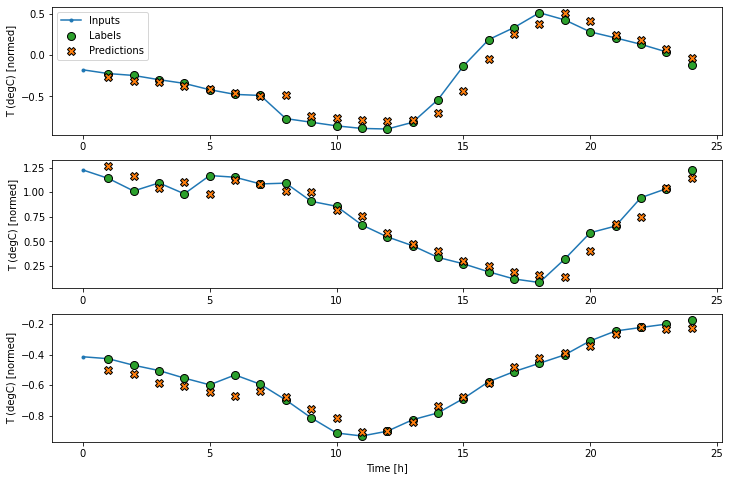

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

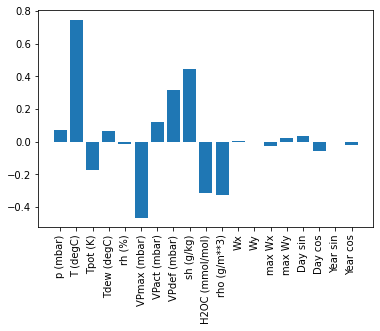

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 15:30 - loss: 1.9957 - mean_absolute_error: 1.1504

  16/1534 [..............................] - ETA: 5s - loss: 0.9703 - mean_absolute_error: 0.6958   

  31/1534 [..............................] - ETA: 5s - loss: 0.5559 - mean_absolute_error: 0.4822

  47/1534 [..............................] - ETA: 5s - loss: 0.3852 - mean_absolute_error: 0.3819

  63/1534 [>.............................] - ETA: 4s - loss: 0.2942 - mean_absolute_error: 0.3185

  79/1534 [>.............................] - ETA: 4s - loss: 0.2391 - mean_absolute_error: 0.2776

  95/1534 [>.............................] - ETA: 4s - loss: 0.2021 - mean_absolute_error: 0.2488

 110/1534 [=>............................] - ETA: 4s - loss: 0.1769 - mean_absolute_error: 0.2288

 126/1534 [=>............................] - ETA: 4s - loss: 0.1565 - mean_absolute_error: 0.2118

 142/1534 [=>............................] - ETA: 4s - loss: 0.1403 - mean_absolute_error: 0.1978

 158/1534 [==>...........................] - ETA: 4s - loss: 0.1274 - mean_absolute_error: 0.1866

 174/1534 [==>...........................] - ETA: 4s - loss: 0.1171 - mean_absolute_error: 0.1777

 190/1534 [==>...........................] - ETA: 4s - loss: 0.1082 - mean_absolute_error: 0.1697

 206/1534 [===>..........................] - ETA: 4s - loss: 0.1008 - mean_absolute_error: 0.1631

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0944 - mean_absolute_error: 0.1572

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0888 - mean_absolute_error: 0.1519

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0840 - mean_absolute_error: 0.1476

 270/1534 [====>.........................] - ETA: 4s - loss: 0.0797 - mean_absolute_error: 0.1437

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0759 - mean_absolute_error: 0.1402

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0725 - mean_absolute_error: 0.1370

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0695 - mean_absolute_error: 0.1343

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0666 - mean_absolute_error: 0.1314

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0640 - mean_absolute_error: 0.1289

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0617 - mean_absolute_error: 0.1266

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0597 - mean_absolute_error: 0.1244

 397/1534 [======>.......................] - ETA: 3s - loss: 0.0576 - mean_absolute_error: 0.1223

 413/1534 [=======>......................] - ETA: 3s - loss: 0.0558 - mean_absolute_error: 0.1204

 429/1534 [=======>......................] - ETA: 3s - loss: 0.0541 - mean_absolute_error: 0.1188

 444/1534 [=======>......................] - ETA: 3s - loss: 0.0526 - mean_absolute_error: 0.1173

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0512 - mean_absolute_error: 0.1158

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0498 - mean_absolute_error: 0.1143

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0486 - mean_absolute_error: 0.1131

 505/1534 [========>.....................] - ETA: 3s - loss: 0.0474 - mean_absolute_error: 0.1119

 520/1534 [=========>....................] - ETA: 3s - loss: 0.0463 - mean_absolute_error: 0.1107

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0452 - mean_absolute_error: 0.1095

 552/1534 [=========>....................] - ETA: 3s - loss: 0.0442 - mean_absolute_error: 0.1085

 567/1534 [==========>...................] - ETA: 3s - loss: 0.0433 - mean_absolute_error: 0.1076

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0423 - mean_absolute_error: 0.1066

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0415 - mean_absolute_error: 0.1056

 614/1534 [===========>..................] - ETA: 3s - loss: 0.0407 - mean_absolute_error: 0.1048

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0399 - mean_absolute_error: 0.1039

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0392 - mean_absolute_error: 0.1031

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0385 - mean_absolute_error: 0.1024

 674/1534 [============>.................] - ETA: 2s - loss: 0.0379 - mean_absolute_error: 0.1017

 689/1534 [============>.................] - ETA: 2s - loss: 0.0372 - mean_absolute_error: 0.1009

 704/1534 [============>.................] - ETA: 2s - loss: 0.0366 - mean_absolute_error: 0.1003

 720/1534 [=============>................] - ETA: 2s - loss: 0.0361 - mean_absolute_error: 0.0996

 736/1534 [=============>................] - ETA: 2s - loss: 0.0355 - mean_absolute_error: 0.0990

 752/1534 [=============>................] - ETA: 2s - loss: 0.0349 - mean_absolute_error: 0.0983

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0343 - mean_absolute_error: 0.0976

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0338 - mean_absolute_error: 0.0969

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0333 - mean_absolute_error: 0.0963

 815/1534 [==============>...............] - ETA: 2s - loss: 0.0329 - mean_absolute_error: 0.0958

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0324 - mean_absolute_error: 0.0952

 847/1534 [===============>..............] - ETA: 2s - loss: 0.0320 - mean_absolute_error: 0.0948

 862/1534 [===============>..............] - ETA: 2s - loss: 0.0316 - mean_absolute_error: 0.0943

 878/1534 [================>.............] - ETA: 2s - loss: 0.0311 - mean_absolute_error: 0.0939

 894/1534 [================>.............] - ETA: 2s - loss: 0.0307 - mean_absolute_error: 0.0933

 910/1534 [================>.............] - ETA: 2s - loss: 0.0303 - mean_absolute_error: 0.0929

 926/1534 [=================>............] - ETA: 2s - loss: 0.0299 - mean_absolute_error: 0.0925

 941/1534 [=================>............] - ETA: 1s - loss: 0.0296 - mean_absolute_error: 0.0921

 957/1534 [=================>............] - ETA: 1s - loss: 0.0293 - mean_absolute_error: 0.0917

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0289 - mean_absolute_error: 0.0913

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0286 - mean_absolute_error: 0.0909

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0283 - mean_absolute_error: 0.0905

1020/1534 [==================>...........] - ETA: 1s - loss: 0.0280 - mean_absolute_error: 0.0902

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0276 - mean_absolute_error: 0.0898

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0273 - mean_absolute_error: 0.0894

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0270 - mean_absolute_error: 0.0889

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0268 - mean_absolute_error: 0.0887

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0265 - mean_absolute_error: 0.0884

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0263 - mean_absolute_error: 0.0882

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0261 - mean_absolute_error: 0.0880

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0258 - mean_absolute_error: 0.0877

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0256 - mean_absolute_error: 0.0874

1179/1534 [======================>.......] - ETA: 1s - loss: 0.0254 - mean_absolute_error: 0.0872

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0251 - mean_absolute_error: 0.0868

1211/1534 [======================>.......] - ETA: 1s - loss: 0.0249 - mean_absolute_error: 0.0866

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0247 - mean_absolute_error: 0.0864

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.0861

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.0859

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.0856

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0854

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0852

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.0849

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0233 - mean_absolute_error: 0.0847

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0845

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.0843

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0228 - mean_absolute_error: 0.0841

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.0838

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.0836

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0834

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.0832

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.0830

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0829

1495/1534 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0827

1511/1534 [============================>.] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.0824

1527/1534 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0823

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0214 - mean_absolute_error: 0.0822 - val_loss: 0.0086 - val_mean_absolute_error: 0.0682


Epoch 2/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0046 - mean_absolute_error: 0.0527

  17/1534 [..............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0627 

  33/1534 [..............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0625

  49/1534 [..............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0620

  65/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0609

  81/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

  97/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0625

 113/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0627

 129/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0625

 145/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 161/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0629

 177/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0637

 208/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0641

 224/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0643

 240/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0645

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0645

 272/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0646

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0644

 303/1534 [====>.........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0644

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0647

 335/1534 [=====>........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0645

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0645

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0646

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0645

 399/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0645

 415/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0644

 430/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0646

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0644

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0644

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0642

 492/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0643

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0643

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0641

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0641

 554/1534 [=========>....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0642

 569/1534 [==========>...................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0642

 585/1534 [==========>...................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0641

 601/1534 [==========>...................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0640

 617/1534 [===========>..................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0640

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0640

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0639

 665/1534 [============>.................] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0639

 681/1534 [============>.................] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0639

 697/1534 [============>.................] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0638

 713/1534 [============>.................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 729/1534 [=============>................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 745/1534 [=============>................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 761/1534 [=============>................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 793/1534 [==============>...............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 872/1534 [================>.............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0639

 888/1534 [================>.............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 904/1534 [================>.............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 920/1534 [================>.............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0638

 936/1534 [=================>............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0637

 952/1534 [=================>............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0637

 968/1534 [=================>............] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0635

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0634

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0635

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1174/1534 [=====================>........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0635

1204/1534 [======================>.......] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0635

1220/1534 [======================>.......] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0636

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1491/1534 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1507/1534 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1523/1534 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0077 - mean_absolute_error: 0.0635 - val_loss: 0.0076 - val_mean_absolute_error: 0.0637


Epoch 3/20


   1/1534 [..............................] - ETA: 39s - loss: 0.0084 - mean_absolute_error: 0.0676

  16/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0622 

  31/1534 [..............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0619

  47/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0606

  64/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0605

  80/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0625

  96/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0632

 112/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0632

 128/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0635

 144/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0629

 160/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0628

 176/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0627

 208/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0627

 224/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 240/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0633

 272/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0631

 288/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0629

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 320/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0633

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 399/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 415/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0635

 447/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 479/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 495/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 511/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 526/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 542/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 558/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 574/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0633

 590/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 606/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 622/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 669/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 685/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0632

 701/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 717/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 732/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 748/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 763/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 778/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0629

 793/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 808/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0629

 837/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 882/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 898/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 913/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 928/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

 943/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

 958/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

 973/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1160/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1176/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

1224/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1493/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1509/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1524/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0622 - val_loss: 0.0072 - val_mean_absolute_error: 0.0616


Epoch 4/20


   1/1534 [..............................] - ETA: 36s - loss: 0.0047 - mean_absolute_error: 0.0541

  16/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0612 

  32/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0609

  48/1534 [..............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0593

  64/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0599

  80/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0600

  96/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0601

 112/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0601

 127/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0603

 143/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0602

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0606

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 239/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0610

 255/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0612

 271/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0609

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 364/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 380/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0611

 396/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0611

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0611

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 571/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 587/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 603/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 619/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0613

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 667/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 683/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 698/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 713/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 729/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 745/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 761/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 808/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 824/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 840/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 872/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 888/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 904/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 920/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 936/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

 952/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0610

 968/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1280/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1498/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1513/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1528/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0606 - val_loss: 0.0076 - val_mean_absolute_error: 0.0649


Epoch 5/20


   1/1534 [..............................] - ETA: 39s - loss: 0.0042 - mean_absolute_error: 0.0536

  15/1534 [..............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0659 

  31/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0644

  47/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0623

  63/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0609

  79/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0617

  95/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

 111/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0621

 127/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0625

 143/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0616

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0617

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0617

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0617

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0616

 239/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0617

 255/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0615

 270/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0611

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0609

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0608

 318/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0609

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 397/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0606

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 537/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 553/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 568/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 615/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 679/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 694/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 710/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 726/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 742/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 758/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 854/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0603

 870/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 886/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0604

 902/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0604

 918/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 934/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 950/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 966/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0605

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0605

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0604

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0604

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0604

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1219/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1488/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1503/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1518/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1534/1534 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0604 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621


  1/439 [..............................] - ETA: 26s - loss: 0.0032 - mean_absolute_error: 0.0459

 19/439 [>.............................] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0621 

 38/439 [=>............................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0605

 56/439 [==>...........................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0612

 74/439 [====>.........................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0620

 93/439 [=====>........................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0618

112/439 [======>.......................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0612

131/439 [=======>......................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0617

151/439 [=========>....................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0618

170/439 [==========>...................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0616

189/439 [===========>..................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0617

209/439 [=============>................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0618

228/439 [==============>...............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0618

247/439 [===============>..............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0619

266/439 [=================>............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0616

285/439 [==================>...........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0618

304/439 [===================>..........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0619

324/439 [=====================>........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0619

343/439 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0618

362/439 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0620

381/439 [=========================>....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

400/439 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0623

419/439 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

438/439 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

439/439 [==============================] - 1s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0621


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

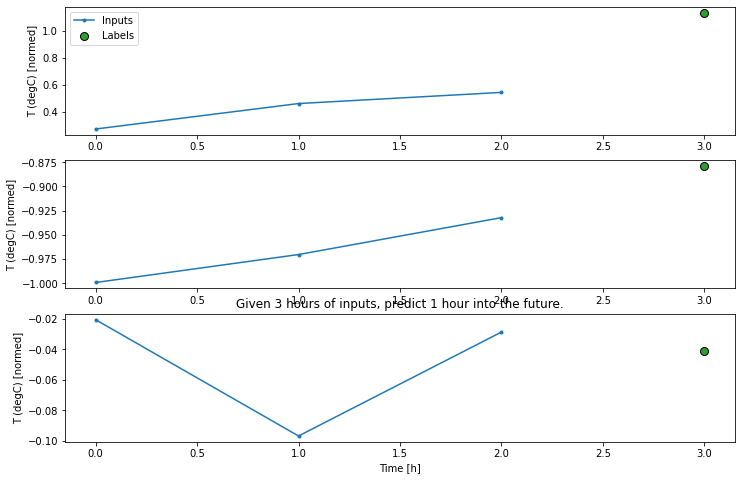

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 26s - loss: 0.0035 - mean_absolute_error: 0.0450

 26/438 [>.............................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0536 

 51/438 [==>...........................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0533

 76/438 [====>.........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0529

100/438 [=====>........................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0527

126/438 [=======>......................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0537

151/438 [=========>....................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0536

176/438 [===========>..................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0537

201/438 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0539

226/438 [==============>...............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0540

251/438 [================>.............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0548

276/438 [=================>............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0545

301/438 [===================>..........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0544

326/438 [=====================>........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0547

351/438 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0546

375/438 [========================>.....] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0544

399/438 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0545

424/438 [============================>.] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0544

438/438 [==============================] - 1s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0546


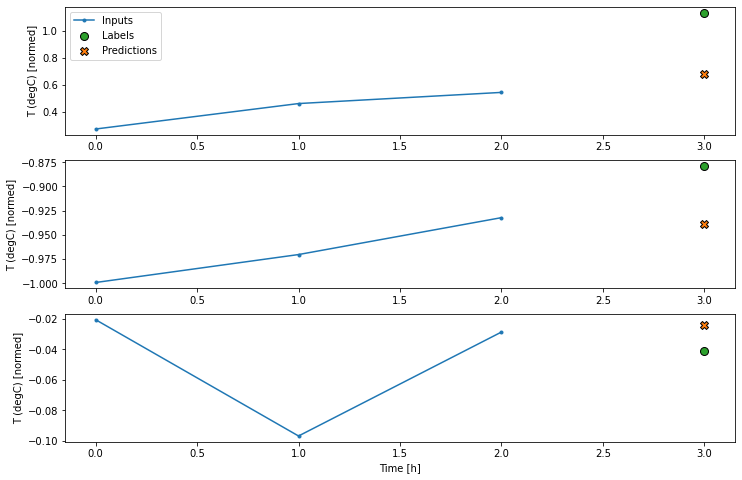

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer "sequential_2" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 26s - loss: 0.0058 - mean_absolute_error: 0.0633

 20/438 [>.............................] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595 

 40/438 [=>............................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0601

 60/438 [===>..........................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0607

 80/438 [====>.........................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0616

100/438 [=====>........................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0622

120/438 [=======>......................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0628

140/438 [========>.....................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

160/438 [=========>....................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0628

180/438 [===========>..................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

200/438 [============>.................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

219/438 [==============>...............] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

238/438 [===============>..............] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0630

258/438 [================>.............] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0626

278/438 [==================>...........] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0629

297/438 [===================>..........] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

316/438 [====================>.........] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

336/438 [======================>.......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

355/438 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

375/438 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

395/438 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

414/438 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

434/438 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

438/438 [==============================] - 1s 3ms/step - loss: 0.0076 - mean_absolute_error: 0.0630


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

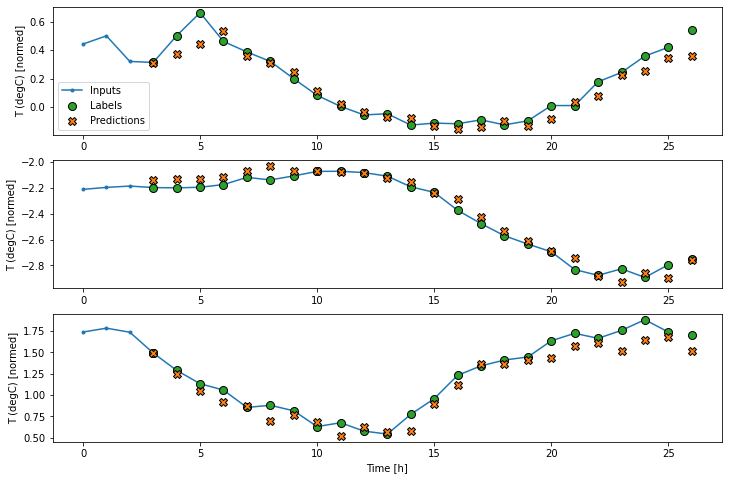

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 26s - loss: 0.0051 - mean_absolute_error: 0.0488

 17/438 [>.............................] - ETA: 1s - loss: 0.0051 - mean_absolute_error: 0.0498 

 34/438 [=>............................] - ETA: 1s - loss: 0.0053 - mean_absolute_error: 0.0504

 51/438 [==>...........................] - ETA: 1s - loss: 0.0054 - mean_absolute_error: 0.0507

 69/438 [===>..........................] - ETA: 1s - loss: 0.0054 - mean_absolute_error: 0.0507

 87/438 [====>.........................] - ETA: 1s - loss: 0.0054 - mean_absolute_error: 0.0508

105/438 [======>.......................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0508

122/438 [=======>......................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

140/438 [========>.....................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

157/438 [=========>....................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

174/438 [==========>...................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

191/438 [============>.................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

208/438 [=============>................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

226/438 [==============>...............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

243/438 [===============>..............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

260/438 [================>.............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

277/438 [=================>............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

295/438 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0511

312/438 [====================>.........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

329/438 [=====================>........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

346/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

364/438 [=======================>......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

382/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

400/438 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

418/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0511

436/438 [============================>.] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0511

438/438 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0511


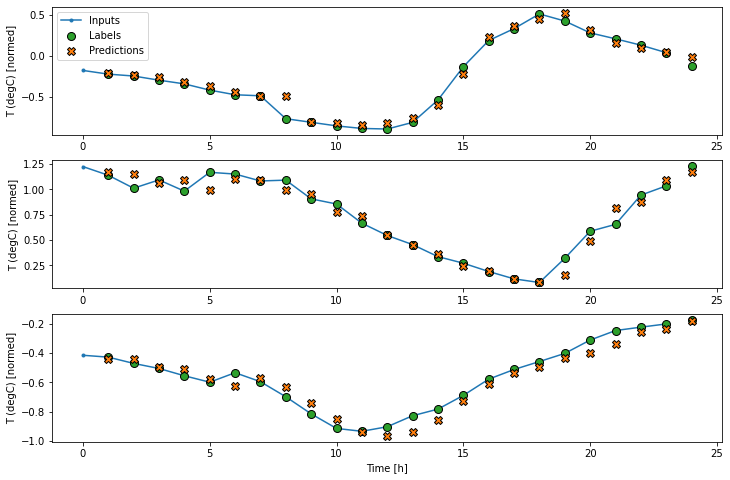

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

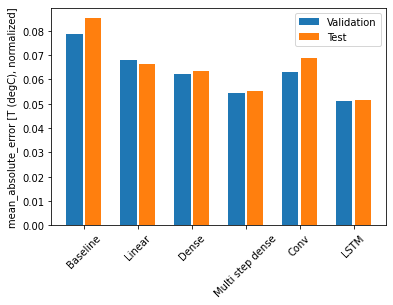

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0663
Dense       : 0.0633
Multi step dense: 0.0552
Conv        : 0.0689
LSTM        : 0.0516


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 55s - loss: 0.1088 - mean_absolute_error: 0.1721

 26/438 [>.............................] - ETA: 0s - loss: 0.0896 - mean_absolute_error: 0.1607 

 53/438 [==>...........................] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1597

 80/438 [====>.........................] - ETA: 0s - loss: 0.0897 - mean_absolute_error: 0.1598

107/438 [======>.......................] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1595

134/438 [========>.....................] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.1595

161/438 [==========>...................] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.1593

187/438 [===========>..................] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.1593

215/438 [=============>................] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1590

242/438 [===============>..............] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.1591

269/438 [=================>............] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1590

296/438 [===================>..........] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1589

323/438 [=====================>........] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

350/438 [======================>.......] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1588

378/438 [========================>.....] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

405/438 [==========================>...] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

432/438 [============================>.] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 26s - loss: 0.0796 - mean_absolute_error: 0.1346

 19/439 [>.............................] - ETA: 1s - loss: 0.0680 - mean_absolute_error: 0.1297 

 38/439 [=>............................] - ETA: 1s - loss: 0.0650 - mean_absolute_error: 0.1284

 57/439 [==>...........................] - ETA: 1s - loss: 0.0654 - mean_absolute_error: 0.1289

 76/439 [====>.........................] - ETA: 0s - loss: 0.0663 - mean_absolute_error: 0.1295

 94/439 [=====>........................] - ETA: 0s - loss: 0.0642 - mean_absolute_error: 0.1277

112/439 [======>.......................] - ETA: 0s - loss: 0.0638 - mean_absolute_error: 0.1275

131/439 [=======>......................] - ETA: 0s - loss: 0.0644 - mean_absolute_error: 0.1278

150/439 [=========>....................] - ETA: 0s - loss: 0.0654 - mean_absolute_error: 0.1286

169/439 [==========>...................] - ETA: 0s - loss: 0.0652 - mean_absolute_error: 0.1284

188/439 [===========>..................] - ETA: 0s - loss: 0.0653 - mean_absolute_error: 0.1287

207/439 [=============>................] - ETA: 0s - loss: 0.0660 - mean_absolute_error: 0.1294

225/439 [==============>...............] - ETA: 0s - loss: 0.0669 - mean_absolute_error: 0.1299

244/439 [===============>..............] - ETA: 0s - loss: 0.0669 - mean_absolute_error: 0.1300

263/439 [================>.............] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.1300

282/439 [==================>...........] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1303

301/439 [===================>..........] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1301

320/439 [====================>.........] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1302

339/439 [======================>.......] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1304

357/439 [=======================>......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1307

376/439 [========================>.....] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1307

395/439 [=========================>....] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1307

414/439 [===========================>..] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1305

433/439 [============================>.] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1303

439/439 [==============================] - 1s 3ms/step - loss: 0.0679 - mean_absolute_error: 0.1303


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 27s - loss: 0.0638 - mean_absolute_error: 0.1216

 16/438 [>.............................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1199 

 33/438 [=>............................] - ETA: 1s - loss: 0.0601 - mean_absolute_error: 0.1191

 50/438 [==>...........................] - ETA: 1s - loss: 0.0596 - mean_absolute_error: 0.1186

 67/438 [===>..........................] - ETA: 1s - loss: 0.0607 - mean_absolute_error: 0.1197

 84/438 [====>.........................] - ETA: 1s - loss: 0.0606 - mean_absolute_error: 0.1196

101/438 [=====>........................] - ETA: 1s - loss: 0.0606 - mean_absolute_error: 0.1195

119/438 [=======>......................] - ETA: 0s - loss: 0.0604 - mean_absolute_error: 0.1193

137/438 [========>.....................] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1197

155/438 [=========>....................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1200

172/438 [==========>...................] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1198

189/438 [===========>..................] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1200

207/438 [=============>................] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1199

224/438 [==============>...............] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1198

241/438 [===============>..............] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1200

258/438 [================>.............] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1199

274/438 [=================>............] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1199

291/438 [==================>...........] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1198

308/438 [====================>.........] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1197

325/438 [=====================>........] - ETA: 0s - loss: 0.0607 - mean_absolute_error: 0.1197

342/438 [======================>.......] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1198

359/438 [=======================>......] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1198

376/438 [========================>.....] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1199

393/438 [=========================>....] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1200

410/438 [===========================>..] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1200

427/438 [============================>.] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1200

438/438 [==============================] - 1s 3ms/step - loss: 0.0611 - mean_absolute_error: 0.1200



CPU times: user 4min 57s, sys: 1min 15s, total: 6min 13s
Wall time: 1min 48s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 26s - loss: 0.0584 - mean_absolute_error: 0.1106

 17/438 [>.............................] - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.1172 

 34/438 [=>............................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1168

 51/438 [==>...........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1169

 69/438 [===>..........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1176

 85/438 [====>.........................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1176

102/438 [=====>........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1177

119/438 [=======>......................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1176

136/438 [========>.....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1174

153/438 [=========>....................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1174

170/438 [==========>...................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1175

187/438 [===========>..................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

204/438 [============>.................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

221/438 [==============>...............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

238/438 [===============>..............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1176

255/438 [================>.............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1175

272/438 [=================>............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1174

289/438 [==================>...........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

307/438 [====================>.........] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1175

324/438 [=====================>........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

342/438 [======================>.......] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

360/438 [=======================>......] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1176

378/438 [========================>.....] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1176

395/438 [==========================>...] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

413/438 [===========================>..] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

430/438 [============================>.] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

438/438 [==============================] - 1s 3ms/step - loss: 0.0620 - mean_absolute_error: 0.1176



CPU times: user 2min 45s, sys: 41.8 s, total: 3min 27s
Wall time: 1min


#### Performance

Here is the overall performance for these multi-output models.

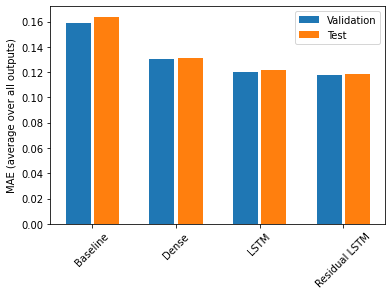

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1313
LSTM           : 0.1215
Residual LSTM  : 0.1189


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

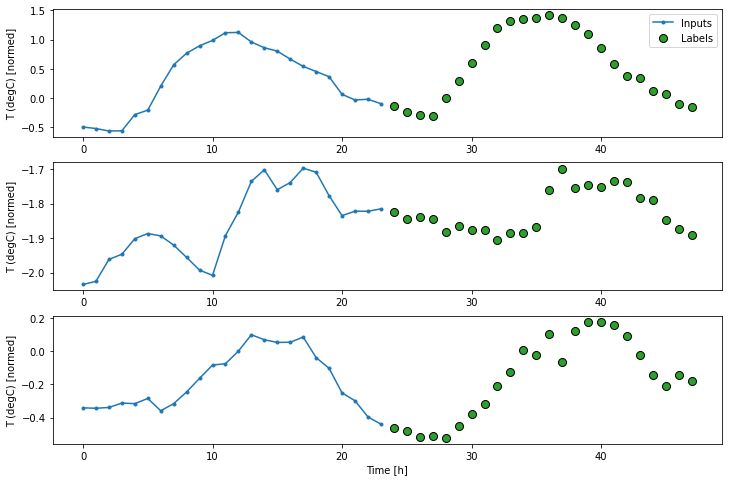

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:15 - loss: 0.5778 - mean_absolute_error: 0.4719

 25/437 [>.............................] - ETA: 0s - loss: 0.6146 - mean_absolute_error: 0.4948  

 51/437 [==>...........................] - ETA: 0s - loss: 0.6106 - mean_absolute_error: 0.4933

 78/437 [====>.........................] - ETA: 0s - loss: 0.6127 - mean_absolute_error: 0.4927

106/437 [======>.......................] - ETA: 0s - loss: 0.6233 - mean_absolute_error: 0.4973

132/437 [========>.....................] - ETA: 0s - loss: 0.6226 - mean_absolute_error: 0.4970

160/437 [=========>....................] - ETA: 0s - loss: 0.6261 - mean_absolute_error: 0.4991

188/437 [===========>..................] - ETA: 0s - loss: 0.6288 - mean_absolute_error: 0.5008

215/437 [=============>................] - ETA: 0s - loss: 0.6294 - mean_absolute_error: 0.5010

242/437 [===============>..............] - ETA: 0s - loss: 0.6293 - mean_absolute_error: 0.5007

269/437 [=================>............] - ETA: 0s - loss: 0.6296 - mean_absolute_error: 0.5006

295/437 [===================>..........] - ETA: 0s - loss: 0.6300 - mean_absolute_error: 0.5014

322/437 [=====================>........] - ETA: 0s - loss: 0.6294 - mean_absolute_error: 0.5012

349/437 [======================>.......] - ETA: 0s - loss: 0.6283 - mean_absolute_error: 0.5007

376/437 [========================>.....] - ETA: 0s - loss: 0.6291 - mean_absolute_error: 0.5011

403/437 [==========================>...] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.5006

430/437 [============================>.] - ETA: 0s - loss: 0.6279 - mean_absolute_error: 0.5005

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


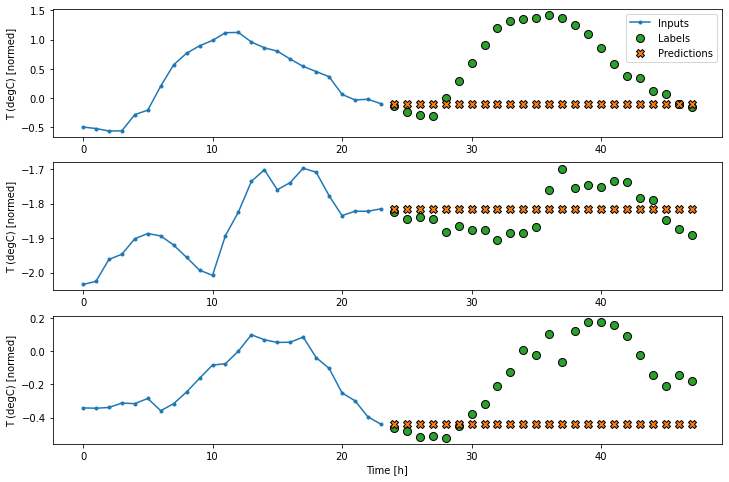

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 1:11 - loss: 0.4799 - mean_absolute_error: 0.4154

 26/437 [>.............................] - ETA: 0s - loss: 0.4317 - mean_absolute_error: 0.4006  

 53/437 [==>...........................] - ETA: 0s - loss: 0.4247 - mean_absolute_error: 0.3946

 80/437 [====>.........................] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3947

107/437 [======>.......................] - ETA: 0s - loss: 0.4289 - mean_absolute_error: 0.3960

134/437 [========>.....................] - ETA: 0s - loss: 0.4256 - mean_absolute_error: 0.3946

161/437 [==========>...................] - ETA: 0s - loss: 0.4258 - mean_absolute_error: 0.3951

189/437 [===========>..................] - ETA: 0s - loss: 0.4234 - mean_absolute_error: 0.3943

216/437 [=============>................] - ETA: 0s - loss: 0.4257 - mean_absolute_error: 0.3954

244/437 [===============>..............] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3957

271/437 [=================>............] - ETA: 0s - loss: 0.4274 - mean_absolute_error: 0.3959

298/437 [===================>..........] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.3958

325/437 [=====================>........] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.3963

351/437 [=======================>......] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3959

378/437 [========================>.....] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.3957

405/437 [==========================>...] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3955

431/437 [============================>.] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3958

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


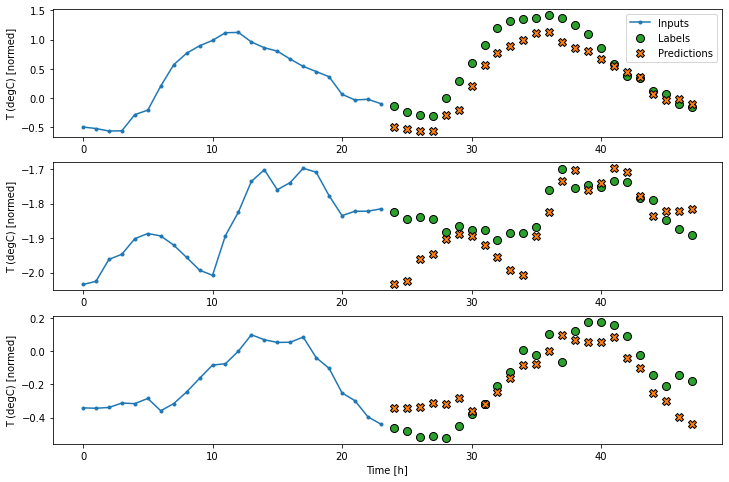

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 25s - loss: 0.2960 - mean_absolute_error: 0.3321

 23/437 [>.............................] - ETA: 0s - loss: 0.2593 - mean_absolute_error: 0.3078 

 46/437 [==>...........................] - ETA: 0s - loss: 0.2540 - mean_absolute_error: 0.3038

 69/437 [===>..........................] - ETA: 0s - loss: 0.2569 - mean_absolute_error: 0.3047

 92/437 [=====>........................] - ETA: 0s - loss: 0.2573 - mean_absolute_error: 0.3051

116/437 [======>.......................] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3043

139/437 [========>.....................] - ETA: 0s - loss: 0.2566 - mean_absolute_error: 0.3051

162/437 [==========>...................] - ETA: 0s - loss: 0.2565 - mean_absolute_error: 0.3050

185/437 [===========>..................] - ETA: 0s - loss: 0.2571 - mean_absolute_error: 0.3050

208/437 [=============>................] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3044

231/437 [==============>...............] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3048

254/437 [================>.............] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3049

277/437 [==================>...........] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3050

300/437 [===================>..........] - ETA: 0s - loss: 0.2566 - mean_absolute_error: 0.3048

323/437 [=====================>........] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3047

346/437 [======================>.......] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3052

369/437 [========================>.....] - ETA: 0s - loss: 0.2566 - mean_absolute_error: 0.3049

392/437 [=========================>....] - ETA: 0s - loss: 0.2566 - mean_absolute_error: 0.3048

416/437 [===========================>..] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3048

437/437 [==============================] - 1s 2ms/step - loss: 0.2559 - mean_absolute_error: 0.3046


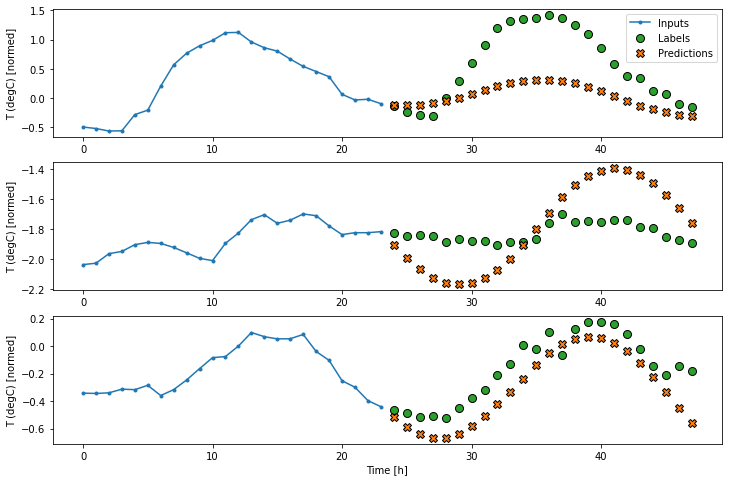

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

  1/437 [..............................] - ETA: 25s - loss: 0.2163 - mean_absolute_error: 0.2860

 20/437 [>.............................] - ETA: 1s - loss: 0.2192 - mean_absolute_error: 0.2838 

 40/437 [=>............................] - ETA: 1s - loss: 0.2198 - mean_absolute_error: 0.2827

 60/437 [===>..........................] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2837

 80/437 [====>.........................] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2846

100/437 [=====>........................] - ETA: 0s - loss: 0.2239 - mean_absolute_error: 0.2862

120/437 [=======>......................] - ETA: 0s - loss: 0.2239 - mean_absolute_error: 0.2862

140/437 [========>.....................] - ETA: 0s - loss: 0.2240 - mean_absolute_error: 0.2865

161/437 [==========>...................] - ETA: 0s - loss: 0.2231 - mean_absolute_error: 0.2856

182/437 [===========>..................] - ETA: 0s - loss: 0.2230 - mean_absolute_error: 0.2855

203/437 [============>.................] - ETA: 0s - loss: 0.2234 - mean_absolute_error: 0.2855

224/437 [==============>...............] - ETA: 0s - loss: 0.2238 - mean_absolute_error: 0.2857

245/437 [===============>..............] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.2860

266/437 [=================>............] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2861

286/437 [==================>...........] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2861

307/437 [====================>.........] - ETA: 0s - loss: 0.2239 - mean_absolute_error: 0.2858

327/437 [=====================>........] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.2860

347/437 [======================>.......] - ETA: 0s - loss: 0.2238 - mean_absolute_error: 0.2858

367/437 [========================>.....] - ETA: 0s - loss: 0.2234 - mean_absolute_error: 0.2856

386/437 [=========================>....] - ETA: 0s - loss: 0.2235 - mean_absolute_error: 0.2857

405/437 [==========================>...] - ETA: 0s - loss: 0.2238 - mean_absolute_error: 0.2860

425/437 [============================>.] - ETA: 0s - loss: 0.2236 - mean_absolute_error: 0.2860

437/437 [==============================] - 1s 3ms/step - loss: 0.2230 - mean_absolute_error: 0.2857


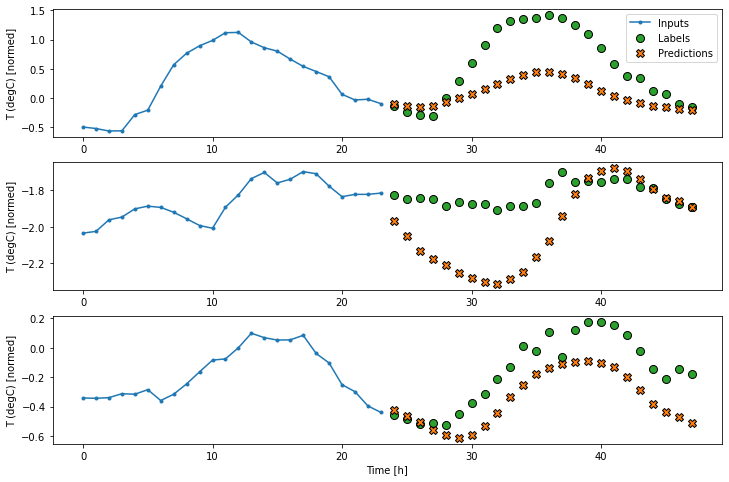

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 24s - loss: 0.1803 - mean_absolute_error: 0.2623

 20/437 [>.............................] - ETA: 1s - loss: 0.2099 - mean_absolute_error: 0.2765 

 41/437 [=>............................] - ETA: 1s - loss: 0.2128 - mean_absolute_error: 0.2787

 62/437 [===>..........................] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2785

 83/437 [====>.........................] - ETA: 0s - loss: 0.2126 - mean_absolute_error: 0.2782

104/437 [======>.......................] - ETA: 0s - loss: 0.2114 - mean_absolute_error: 0.2773

125/437 [=======>......................] - ETA: 0s - loss: 0.2118 - mean_absolute_error: 0.2775

146/437 [=========>....................] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2779

167/437 [==========>...................] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2784

189/437 [===========>..................] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2786

209/437 [=============>................] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2781

228/437 [==============>...............] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2780

248/437 [================>.............] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2783

268/437 [=================>............] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2781

289/437 [==================>...........] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.2777

311/437 [====================>.........] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2780

332/437 [=====================>........] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2778

354/437 [=======================>......] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2778

376/437 [========================>.....] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2780

397/437 [==========================>...] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2777

417/437 [===========================>..] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2777

437/437 [==============================] - 1s 2ms/step - loss: 0.2131 - mean_absolute_error: 0.2777


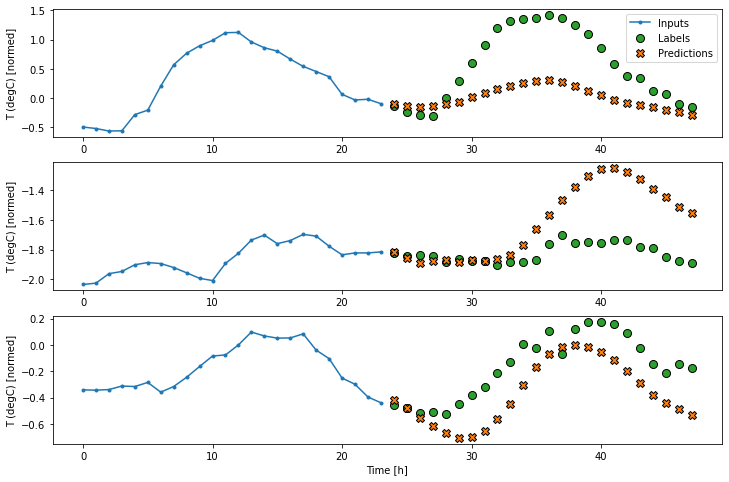

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 24s - loss: 0.1794 - mean_absolute_error: 0.2615

 18/437 [>.............................] - ETA: 1s - loss: 0.2079 - mean_absolute_error: 0.2778 

 37/437 [=>............................] - ETA: 1s - loss: 0.2145 - mean_absolute_error: 0.2820

 56/437 [==>...........................] - ETA: 1s - loss: 0.2112 - mean_absolute_error: 0.2805

 75/437 [====>.........................] - ETA: 0s - loss: 0.2113 - mean_absolute_error: 0.2817

 94/437 [=====>........................] - ETA: 0s - loss: 0.2107 - mean_absolute_error: 0.2815

113/437 [======>.......................] - ETA: 0s - loss: 0.2104 - mean_absolute_error: 0.2818

132/437 [========>.....................] - ETA: 0s - loss: 0.2101 - mean_absolute_error: 0.2815

150/437 [=========>....................] - ETA: 0s - loss: 0.2116 - mean_absolute_error: 0.2824

169/437 [==========>...................] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.2833

188/437 [===========>..................] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2840

206/437 [=============>................] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2840

224/437 [==============>...............] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2847

242/437 [===============>..............] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2843

261/437 [================>.............] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2846

279/437 [==================>...........] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2842

298/437 [===================>..........] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2839

317/437 [====================>.........] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.2839

336/437 [======================>.......] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2839

355/437 [=======================>......] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2838

374/437 [========================>.....] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2840

392/437 [=========================>....] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2841

411/437 [===========================>..] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2840

429/437 [============================>.] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2838

437/437 [==============================] - 1s 3ms/step - loss: 0.2143 - mean_absolute_error: 0.2839


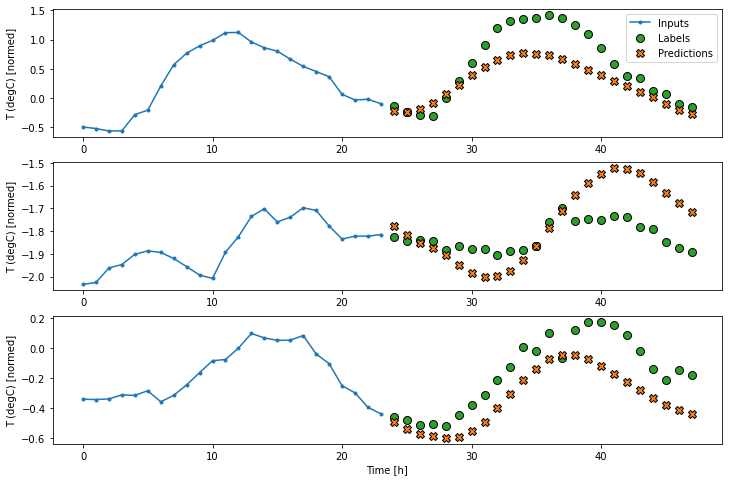

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

  1/437 [..............................] - ETA: 27s - loss: 0.2315 - mean_absolute_error: 0.3122

  7/437 [..............................] - ETA: 3s - loss: 0.2158 - mean_absolute_error: 0.2936 

 13/437 [..............................] - ETA: 3s - loss: 0.2261 - mean_absolute_error: 0.3006

 20/437 [>.............................] - ETA: 3s - loss: 0.2203 - mean_absolute_error: 0.2972

 27/437 [>.............................] - ETA: 3s - loss: 0.2209 - mean_absolute_error: 0.2984

 33/437 [=>............................] - ETA: 3s - loss: 0.2206 - mean_absolute_error: 0.2981

 40/437 [=>............................] - ETA: 3s - loss: 0.2187 - mean_absolute_error: 0.2969

 47/437 [==>...........................] - ETA: 3s - loss: 0.2188 - mean_absolute_error: 0.2970

 53/437 [==>...........................] - ETA: 3s - loss: 0.2181 - mean_absolute_error: 0.2965

 60/437 [===>..........................] - ETA: 3s - loss: 0.2188 - mean_absolute_error: 0.2963

 66/437 [===>..........................] - ETA: 3s - loss: 0.2178 - mean_absolute_error: 0.2954

 73/437 [====>.........................] - ETA: 3s - loss: 0.2204 - mean_absolute_error: 0.2969

 80/437 [====>.........................] - ETA: 2s - loss: 0.2206 - mean_absolute_error: 0.2970

 86/437 [====>.........................] - ETA: 2s - loss: 0.2216 - mean_absolute_error: 0.2976

 93/437 [=====>........................] - ETA: 2s - loss: 0.2205 - mean_absolute_error: 0.2971

100/437 [=====>........................] - ETA: 2s - loss: 0.2213 - mean_absolute_error: 0.2971

107/437 [======>.......................] - ETA: 2s - loss: 0.2222 - mean_absolute_error: 0.2976

114/437 [======>.......................] - ETA: 2s - loss: 0.2222 - mean_absolute_error: 0.2978

121/437 [=======>......................] - ETA: 2s - loss: 0.2226 - mean_absolute_error: 0.2980

128/437 [=======>......................] - ETA: 2s - loss: 0.2225 - mean_absolute_error: 0.2978

135/437 [========>.....................] - ETA: 2s - loss: 0.2242 - mean_absolute_error: 0.2987

141/437 [========>.....................] - ETA: 2s - loss: 0.2244 - mean_absolute_error: 0.2987

147/437 [=========>....................] - ETA: 2s - loss: 0.2247 - mean_absolute_error: 0.2988

153/437 [=========>....................] - ETA: 2s - loss: 0.2245 - mean_absolute_error: 0.2986

159/437 [=========>....................] - ETA: 2s - loss: 0.2243 - mean_absolute_error: 0.2983

165/437 [==========>...................] - ETA: 2s - loss: 0.2246 - mean_absolute_error: 0.2985

171/437 [==========>...................] - ETA: 2s - loss: 0.2240 - mean_absolute_error: 0.2981

178/437 [===========>..................] - ETA: 2s - loss: 0.2234 - mean_absolute_error: 0.2979

185/437 [===========>..................] - ETA: 2s - loss: 0.2227 - mean_absolute_error: 0.2975

191/437 [============>.................] - ETA: 2s - loss: 0.2231 - mean_absolute_error: 0.2977

198/437 [============>.................] - ETA: 1s - loss: 0.2226 - mean_absolute_error: 0.2976

204/437 [=============>................] - ETA: 1s - loss: 0.2226 - mean_absolute_error: 0.2976

211/437 [=============>................] - ETA: 1s - loss: 0.2226 - mean_absolute_error: 0.2976

218/437 [=============>................] - ETA: 1s - loss: 0.2233 - mean_absolute_error: 0.2981

224/437 [==============>...............] - ETA: 1s - loss: 0.2233 - mean_absolute_error: 0.2981

230/437 [==============>...............] - ETA: 1s - loss: 0.2238 - mean_absolute_error: 0.2983

236/437 [===============>..............] - ETA: 1s - loss: 0.2236 - mean_absolute_error: 0.2982

242/437 [===============>..............] - ETA: 1s - loss: 0.2237 - mean_absolute_error: 0.2981

249/437 [================>.............] - ETA: 1s - loss: 0.2242 - mean_absolute_error: 0.2983

255/437 [================>.............] - ETA: 1s - loss: 0.2240 - mean_absolute_error: 0.2983

262/437 [================>.............] - ETA: 1s - loss: 0.2238 - mean_absolute_error: 0.2983

268/437 [=================>............] - ETA: 1s - loss: 0.2240 - mean_absolute_error: 0.2983

275/437 [=================>............] - ETA: 1s - loss: 0.2238 - mean_absolute_error: 0.2981

282/437 [==================>...........] - ETA: 1s - loss: 0.2238 - mean_absolute_error: 0.2981

288/437 [==================>...........] - ETA: 1s - loss: 0.2241 - mean_absolute_error: 0.2983

295/437 [===================>..........] - ETA: 1s - loss: 0.2244 - mean_absolute_error: 0.2985

302/437 [===================>..........] - ETA: 1s - loss: 0.2239 - mean_absolute_error: 0.2982

308/437 [====================>.........] - ETA: 1s - loss: 0.2235 - mean_absolute_error: 0.2979

314/437 [====================>.........] - ETA: 1s - loss: 0.2239 - mean_absolute_error: 0.2982

320/437 [====================>.........] - ETA: 0s - loss: 0.2243 - mean_absolute_error: 0.2983

326/437 [=====================>........] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2983

333/437 [=====================>........] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.2982

339/437 [======================>.......] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2983

345/437 [======================>.......] - ETA: 0s - loss: 0.2246 - mean_absolute_error: 0.2984

351/437 [=======================>......] - ETA: 0s - loss: 0.2248 - mean_absolute_error: 0.2984

357/437 [=======================>......] - ETA: 0s - loss: 0.2246 - mean_absolute_error: 0.2983

363/437 [=======================>......] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.2983

369/437 [========================>.....] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2981

375/437 [========================>.....] - ETA: 0s - loss: 0.2245 - mean_absolute_error: 0.2982

381/437 [=========================>....] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2981

387/437 [=========================>....] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2980

393/437 [=========================>....] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2980

399/437 [==========================>...] - ETA: 0s - loss: 0.2245 - mean_absolute_error: 0.2982

405/437 [==========================>...] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2983

411/437 [===========================>..] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.2984

418/437 [===========================>..] - ETA: 0s - loss: 0.2245 - mean_absolute_error: 0.2984

424/437 [============================>.] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.2985

431/437 [============================>.] - ETA: 0s - loss: 0.2244 - mean_absolute_error: 0.2984

437/437 [==============================] - 4s 8ms/step - loss: 0.2243 - mean_absolute_error: 0.2983


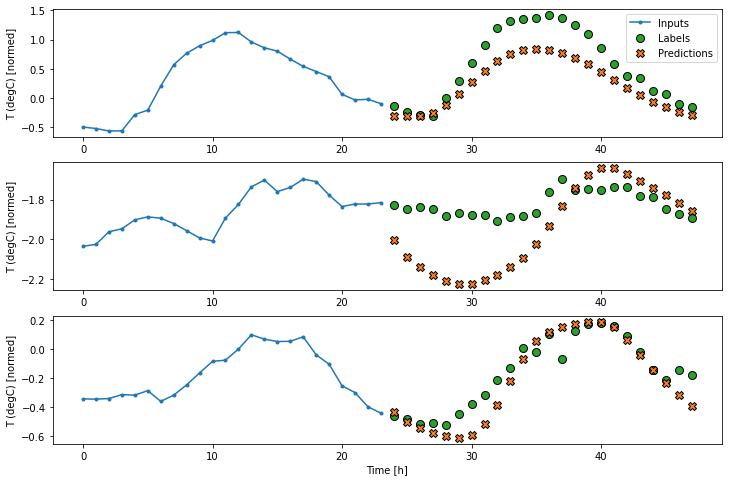

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

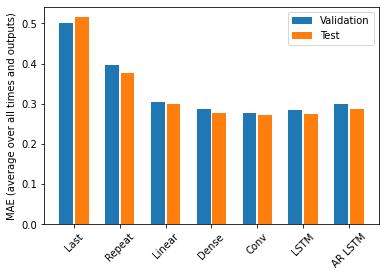

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2980
Dense   : 0.2778
Conv    : 0.2725
LSTM    : 0.2743
AR LSTM : 0.2876


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
